In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_parquet("../training_set.parquet")

In [3]:
class SimpleNN(nn.Module):
   def __init__(self):
      super(SimpleNN, self).__init__()
      self.fc1 = nn.Linear(4, 128)
      self.fc2 = nn.Linear(128, 256)
      self.fc3 = nn.Linear(256, 128)
      self.fc4 = nn.Linear(128, 64)
      self.fc5 = nn.Linear(64, 12)

      self.flat = nn.Flatten()
      self.relu = nn.LeakyReLU(negative_slope=0.01)

   def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [4]:
X = df.drop("Label_Index", axis=1).values
y = df["Label_Index"].values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

torch_df = TensorDataset(X_tensor, y_tensor)

In [5]:
model = SimpleNN()
model.train()

k = 5   
kf = StratifiedKFold(n_splits=k)
accuracies = []

for train_idx, test_idx in kf.split(X,y):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=1e-5)

  train_loader = DataLoader(torch.utils.data.Subset(torch_df, train_idx), batch_size=64, shuffle=True)
  test_loader = DataLoader(torch.utils.data.Subset(torch_df, test_idx), batch_size=64, shuffle=False)
  
  for epoch in range(10):
    running_loss = 0.0

    for inputs, labels in train_loader:
      
      optimizer.zero_grad()
    
      outputs = model(inputs)
  
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
      running_loss += loss.item() * inputs.size(0)
  
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

Epoch 1, Loss: 0.7261
Epoch 2, Loss: 0.6225
Epoch 3, Loss: 0.5936
Epoch 4, Loss: 0.5786
Epoch 5, Loss: 0.5646
Epoch 6, Loss: 0.5558
Epoch 7, Loss: 0.5495
Epoch 8, Loss: 0.5458
Epoch 9, Loss: 0.5423
Epoch 10, Loss: 0.5401
Epoch 1, Loss: 0.6294
Epoch 2, Loss: 0.6203
Epoch 3, Loss: 0.6176
Epoch 4, Loss: 0.6153
Epoch 5, Loss: 0.6135
Epoch 6, Loss: 0.6124
Epoch 7, Loss: 0.6102
Epoch 8, Loss: 0.6088
Epoch 9, Loss: 0.6083
Epoch 10, Loss: 0.6070
Epoch 1, Loss: 0.5978
Epoch 2, Loss: 0.5968
Epoch 3, Loss: 0.5957
Epoch 4, Loss: 0.5949
Epoch 5, Loss: 0.5935
Epoch 6, Loss: 0.5928
Epoch 7, Loss: 0.5918
Epoch 8, Loss: 0.5915
Epoch 9, Loss: 0.5898
Epoch 10, Loss: 0.5895
Epoch 1, Loss: 0.5859
Epoch 2, Loss: 0.5856
Epoch 3, Loss: 0.5847
Epoch 4, Loss: 0.5839
Epoch 5, Loss: 0.5835
Epoch 6, Loss: 0.5826
Epoch 7, Loss: 0.5821
Epoch 8, Loss: 0.5820
Epoch 9, Loss: 0.5813
Epoch 10, Loss: 0.5808
Epoch 1, Loss: 0.5836
Epoch 2, Loss: 0.5830
Epoch 3, Loss: 0.5829
Epoch 4, Loss: 0.5827
Epoch 5, Loss: 0.5854
Epoch 

In [6]:
from sklearn.metrics import classification_report

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11446
           1       0.06      0.00      0.00     11399
           2       0.89      0.91      0.90     11392
           3       0.98      0.95      0.97     11389
           4       0.49      0.79      0.60     11375
           5       0.22      0.02      0.03     11374
           6       0.51      0.03      0.06     11372
           7       0.98      1.00      0.99     11366
           8       0.48      0.93      0.64     11313
           9       0.66      0.86      0.75     11308
          10       0.99      0.99      0.99     11307
          11       1.00      1.00      1.00     11046

    accuracy                           0.71    136087
   macro avg       0.65      0.71      0.63    136087
weighted avg       0.65      0.71      0.63    136087



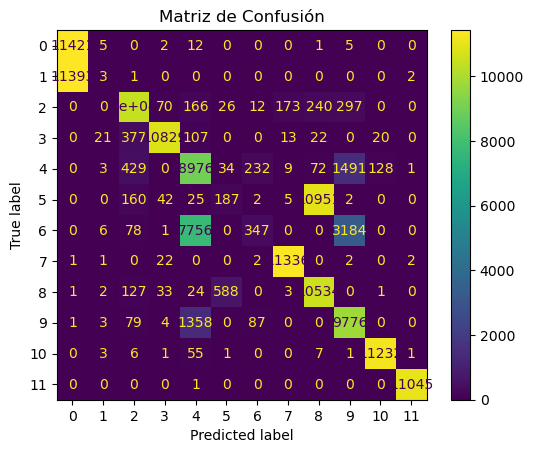

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Matriz de Confusión')
plt.show()
